<a href="https://colab.research.google.com/github/quillaur/data_learning/blob/main/data_science/computer_vision/slearn_image_classification_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

The goal of this project it to identify if a pictures contains a horse or not. We are thus dealing with a classification problem. It can be viewed in 2 ways: a one class classification or a binary one.

We will first look at the dataset content and describe it. Then, features will be extracted from images and processed into a classifier. Performances will be evaluated using the accuracy.

Since it is imposed on us, we will use sklearn only to do our analysis and modelisation.

# Module imports

In [7]:
import cv2
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

# The dataset can be easily obtained from TF.
from tensorflow.keras.datasets import cifar10

from sklearn.svm import SVC
from sklearn.model_selection import cross_validate, train_test_split

# Dataset exploration

## Loading the data

https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10/load_data

In [12]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [13]:
X_train.shape

(50000, 32, 32, 3)

In [14]:
# I limit the train dataset to 100 images for for demonstration purpose.
X_train, _, y_train, _ = train_test_split(X_train, y_train, test_size=0.998, random_state=42)

In [15]:
X_train.shape

(100, 32, 32, 3)

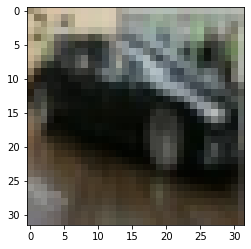

In [16]:
plt.imshow(X_train[0])

## Size visualisation

Not very usefull in our case, but in most real life datasets, the images are not all the same sizes to begin with.

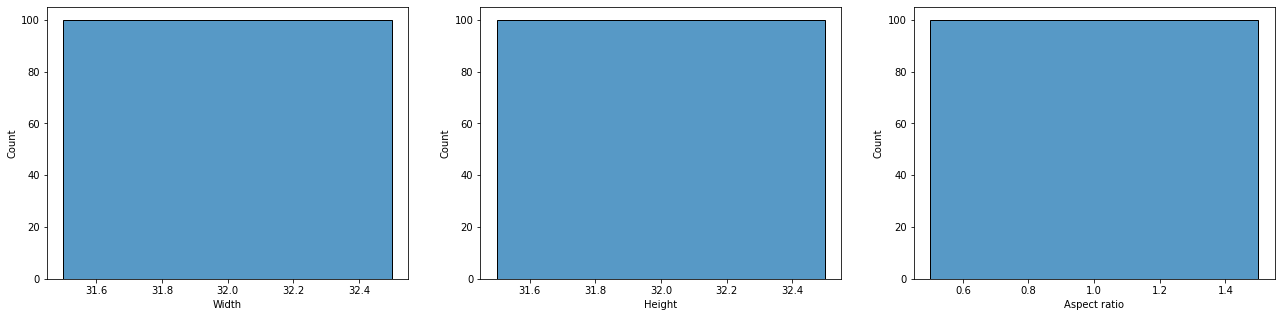

In [19]:
widths = []
heights = []
aspect_ratios = []

for img in X_train:
  # We can get the width (w) and height (h) from the shape of the array.
  w, h, c = img.shape
  widths.append(w)
  heights.append(h)
  aspect_ratios.append(w/h)

vis_df = pd.DataFrame(
  {
    "Width": widths,
    "Height": heights,
    "Aspect ratio": aspect_ratios,
    "Category": y_train.flatten()
  }
)

fig, axes = plt.subplots(1, 3, figsize=(22,5))
# sns.scatterplot(data=vis_df, x="Width", y="Height", hue="Category", ax=axes[0])
sns.histplot(data=vis_df, x="Width", ax=axes[0])
sns.histplot(data=vis_df, x="Height", ax=axes[1])
sns.histplot(data=vis_df, x="Aspect ratio", ax=axes[2])

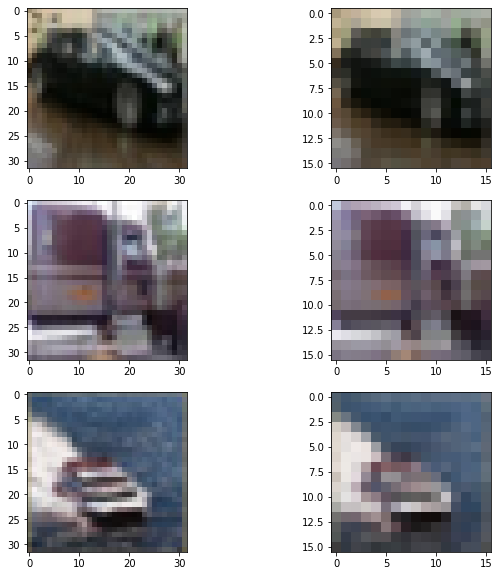

In [21]:
# What happens when I resize pictures ?
pict_numb = 3
resizing = (16,16)

fig, axes = plt.subplots(pict_numb, 2, figsize=(10,10))
for i in range(pict_numb):
  img = X_train[i]
  img_resized = cv2.resize(img, resizing)
  axes[i,0].imshow(img)
  axes[i,1].imshow(img_resized)

## Dataset balance

The category number 7 is one interesting to us. The dataset is slightly unbalanced.

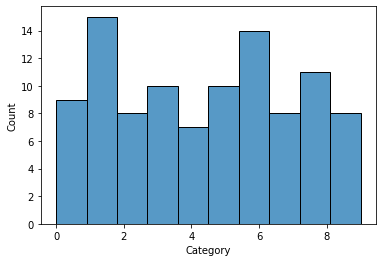

In [36]:
sns.histplot(pd.Series(y_train.flatten(), name="Category"), bins=10)

# Preprocessing

In [37]:
def preprocessing(img: np.ndarray, resize: tuple=(32,32), grayscale: bool=True, equal_hist: bool=True) -> np.ndarray:
  if img.shape[0] != resize[0] and img.shape[1] != resize[1]:
    img = cv2.resize(img, resizing)

  if grayscale:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  
  if equal_hist:
    img = cv2.equalizeHist(img)
  
  return img

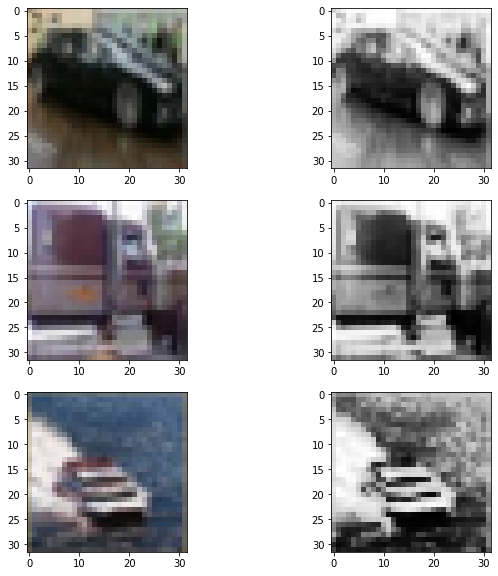

In [39]:
pict_numb = 3
grayscale = True

fig, axes = plt.subplots(pict_numb, 2, figsize=(10,10))
for i in range(pict_numb):
  img = X_train[i]
  axes[i,0].imshow(img)
  axes[i,1].imshow(preprocessing(img, grayscale=grayscale), cmap="gray" if grayscale else "'viridis'")

In [44]:
preprocessed_data = []
for img in tqdm(X_train):
  preprocessed_data.append(preprocessing(img))

  0%|          | 0/100 [00:00<?, ?it/s]

# Features Extraction

* https://www.kaggle.com/code/lorinc/feature-extraction-from-images
* https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.image.PatchExtractor.html#sklearn.feature_extraction.image.PatchExtractor


In [41]:
from skimage.feature import corner_harris, corner_subpix, corner_peaks, CENSURE

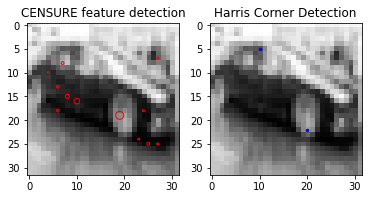

In [47]:
detector = CENSURE()
img = preprocessed_data[0]
detector.detect(img)

coords = corner_peaks(corner_harris(img), min_distance=5)
coords_subpix = corner_subpix(img, coords, window_size=13)

plt.subplot(121)
plt.title('CENSURE feature detection')
plt.imshow(img, cmap="gray")
plt.scatter(detector.keypoints[:, 1], detector.keypoints[:, 0],
              2 ** detector.scales, facecolors='none', edgecolors='r')

plt.subplot(122)
plt.title('Harris Corner Detection')
plt.imshow(img, cmap='gray')
plt.plot(coords[:, 1], coords[:, 0], '.b', markersize=5)
plt.show()

# Sklearn modelisation

https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html

In [34]:
clf = SVC(gamma=0.001)
cv_results = cross_validate(clf, preprocessed_data, target, cv=3)

In [36]:
pd.DataFrame(cv_results)

,fit_time,score_time,test_score
0,0.051047,0.030553,0.5
1,0.031859,0.023418,0.5
2,0.017257,0.039434,0.4


# Using pretrained-model

https://huggingface.co/tasks/image-classification